In [1]:
import numpy as np
from scipy.special import kv  # modified Bessel function of the second kind: K_v
import math
from typing import Tuple, Optional
import matplotlib.pyplot as plt

In [ ]:
def infotaxis(runtime: int,
              pos_x: int,
              pos_y: int,
              sourcex: int,
              sourcey: int,
              dimx: int,
              dimy: int,
              tau: float,
              D: float,
              rate: float,
              particle_size: float,
              gauss_sig: float,
              nowherebase: float = -300.0) -> Tuple[np.ndarray, dict, np.ndarray]:
    """
    Python port of MATLAB `infotaxis.m`.

    Parameters
    ----------
    runtime : int
        Number of time bins to run.
    pos_x, pos_y : int
        Initial position (1-based indices, to match MATLAB).
    sourcex, sourcey : int
        Center of Gaussian prior over source location (1-based).
    dimx, dimy : int
        Arena dimensions.
    tau : float
        Prior belief about lifetime of emitted particles.
    D : float
        Diffusion rate of emitted particles.
    rate : float
        Emission rate of particles.
    particle_size : float
        Relative size of particles.
    gauss_sig : float
        Variance of Gaussian prior.
    nowherebase : float, optional
        Initial log-probability that the food is nowhere in the arena.
    use_particles : bool, optional
        Keep behavior parity with MATLAB flag (not used in decision here).
    runonflag : bool, optional
        Whether to allow running on even if stuck at borders.
    plot_live : bool, optional
        If True, plots the path as it evolves (matplotlib required).
    rng : np.random.Generator, optional
        Random generator for tie-breaks. If None, uses default.
    
    Returns
    -------
    path : (T, 2) ndarray of int
        Trajectory (1-based indices, like MATLAB).
    debug : dict
        Placeholder for debug values (kept for API parity).
    A : (runtime+1, dimx, dimy) ndarray of float
        Log-probability tensor snapshots (Lt) over time.
    """

    rng = np.random.default_rng()

    # Keep 1-based indexing semantics externally; internal arrays are 0-based
    # but we will be careful when indexing with positions.

    dt = 1.0
    lam = math.sqrt(D * tau)

    # --- Precompute the Bessel K0 distance matrix over a large window ----
    # MATLAB builds a (2*dimx+1) x (2*dimy+1) grid (after transpose).
    xs = np.arange(-dimx, dimx + 1, dtype=float)
    ys = np.arange(-dimy, dimy + 1, dtype=float)
    XX, YY = np.meshgrid(xs, ys, indexing='xy')  # shape (2*dimy+1, 2*dimx+1)
    r_over_lambda = np.sqrt(XX**2 + YY**2) / lam

    # kv(0, 0) -> inf; like the MATLAB code, set NaN/Inf to 0 after computing
    bessel_matr = kv(0, r_over_lambda)
    bessel_matr = np.where(np.isfinite(bessel_matr), bessel_matr, 0.0)
    # MATLAB transposes after building; match their memory/view by transposing
    bessel_matr = bessel_matr.T  # shape (2*dimx+1, 2*dimy+1)

    centerx = dimx  # zero-based index of center along x in our transposed array
    centery = dimy  # zero-based index of center along y

    def besselk3(ix, iy):
        """
        Return the submatrix (dimx x dimy) corresponding to position (ix,iy),
        where ix,iy are 1-based (MATLAB-style).
        Slicing is inclusive on both sides in MATLAB; Python slice end is exclusive,
        so add +1 to upper bounds.
        """
        # Convert to 0-based MATLAB-like offsets for slicing
        # MATLAB:
        #   rows: (centerx-(pos_x-1)) : (centerx+(dimx-pos_x))
        #   cols: (centery-(pos_y-1)) : (centery+(dimy-pos_y))
        # Python slices are [start:end), so +1 on end.
        row_start = centerx - (ix - 1)
        row_end   = centerx + (dimx - ix) + 1
        col_start = centery - (iy - 1)
        col_end   = centery + (dimy - iy) + 1
        return bessel_matr[row_start:row_end, col_start:col_end]

    # Helper functions (use closures so they see current Lt/pA when needed)
    def R(ix, iy):
        # rate / log2(lambda / particle_size) * K0(...)
        # Guard lambda/particle_size <= 0; if problematic, fall back to 1 to avoid div by 0
        denom = np.log2(lam / particle_size) if lam > 0 and particle_size > 0 else 1.0
        return (rate / denom) * besselk3(ix, iy)

    def p0y(ix, iy):  # probability of zero hit given position (ix,iy)
        return np.exp(-R(ix, iy))

    def p1y(ix, iy):  # probability of a hit
        return 1.0 - p0y(ix, iy)

    def p0(ix, iy, pA_lin, Pt_lin):
        # (1-pA)*sum(Pt.*p0y) + pA
        return (1.0 - pA_lin) * np.nansum(Pt_lin * p0y(ix, iy)) + pA_lin

    def p1(ix, iy, pA_lin, Pt_lin):
        # (1-pA)*sum(Pt.*p1y)
        return (1.0 - pA_lin) * np.nansum(Pt_lin * p1y(ix, iy))

    # --- Build initial log-likelihood grid Lt (Gaussian prior over source) ---
    # In MATLAB, they build using distances from (sourcex, sourcey) (1-based).
    # We'll create an array of shape (dimx, dimy) addressed as [ix-1, iy-1].
    xs_grid = np.arange(1, dimx + 1)
    ys_grid = np.arange(1, dimy + 1)
    Xg, Yg = np.meshgrid(xs_grid, ys_grid, indexing='ij')  # shape (dimx, dimy)

    dist = np.sqrt((Xg - sourcex)**2 + (Yg - sourcey)**2)
    Lt = - (dist**2) / gauss_sig
    # Normalize to log-space (subtract log-sum-exp)
    # Lt_norm = log(sum(exp(Lt))) -> subtract it so that sum(exp(Lt)) == 1
    Lt = Lt - np.log(np.sum(np.exp(Lt)))

    debug = {}

    # A will store Lt snapshots
    A = np.zeros((runtime + 1, dimx, dimy), dtype=float)

    path = [np.array([pos_x, pos_y], dtype=int)]

    # --- Main loop ---
    pA_log = float(nowherebase)  # log-probability that source is nowhere
    for t in range(runtime + 1):
        # Normalize Lt in log-space so sum(exp(Lt)) == 1
        Lt = Lt - math.log(np.sum(np.exp(Lt)))
        # Update pA in log-space:
        pA_log = pA_log - math.log(p0(pos_x, pos_y, math.exp(pA_log), np.exp(Lt)))
        # Clamp: if > 0, set to 0  (i.e., cap at log(1))
        if pA_log > 0:
            pA_log = 0.0

        # Entropy S of current belief (exclude underflows)
        Pt = np.exp(Lt)
        mask = Pt > 1e-300
        S = -np.sum(Pt[mask] * (np.log2(Pt[mask])))

        pA0 = math.exp(pA_log)

        def move_entropy(ix, iy) -> float:
            """Compute expected change in entropy for moving to (ix, iy)."""
            L0 = np.exp(Lt)
            L0[ix - 1, iy - 1] = 0.0

            # Case: zero hit
            L0_zero = L0 * np.exp(-R(ix, iy))
            L0_zero = np.where(np.isnan(L0_zero), 0.0, L0_zero)
            norm0 = np.sum(L0_zero)
            if norm0 > 0:
                P0 = L0_zero / norm0
                m0 = P0 > 1e-300
                S0 = -np.sum(P0[m0] * np.log2(P0[m0]))
            else:
                S0 = 0.0
            S0 = p0(ix, iy, pA0, np.exp(Lt)) * (S0 - S)

            # Case: at least one hit
            L0_one = L0 * (1.0 - np.exp(-R(ix, iy)))
            L0_one = np.where(np.isnan(L0_one), 0.0, L0_one)
            norm1 = np.sum(L0_one)
            if norm1 > 0:
                P1 = L0_one / norm1
                m1 = P1 > 1e-300
                S1 = -np.sum(P1[m1] * np.log2(P1[m1]))
                if not np.isfinite(S1):
                    S1 = 0.0
            else:
                S1 = 0.0
            S1 = p1(ix, iy, pA0, np.exp(Lt)) * (S1 - S)

            # Immediate reward if the source is exactly at (ix,iy)
            hit_term = np.exp(Lt[ix - 1, iy - 1]) * (-S)
            miss_term = (1.0 - np.exp(Lt[ix - 1, iy - 1])) * (S0 + S1)
            return hit_term + miss_term

        # Compute expected entropy change for five actions
        big = 1_000_000.0

        # up: (pos_y+1)
        if pos_y + 1 < dimy:
            up = move_entropy(pos_x, pos_y + 1)
        else:
            up = big

        # down: (pos_y-1)
        if pos_y - 1 > 0:
            down = move_entropy(pos_x, pos_y - 1)
        else:
            down = big

        # left: (pos_x-1)
        if pos_x - 1 > 0:
            left = move_entropy(pos_x - 1, pos_y)
        else:
            left = big

        # right: (pos_x+1)
        if pos_x + 1 < dimx:
            right = move_entropy(pos_x + 1, pos_y)
        else:
            right = big

        # stay:
        stay = move_entropy(pos_x, pos_y)

        # Record Lt
        A[t, :, :] = Lt

        # Decision matrix (same layout as MATLAB)
        dc = max(up, down, left, right, stay) + 10.0
        decision_matr = np.array([
            [dc,   down, dc],
            [left, stay, right],
            [dc,   up,   dc]
        ])
        mval = decision_matr.min()
        decisions = np.argwhere(decision_matr == mval)

        # Tie-break uniformly
        if len(decisions) > 1:
            choice_idx = rng.integers(0, len(decisions))
            chosen = decisions[choice_idx]
        else:
            chosen = decisions[0]

        movey, movex = chosen  # MATLAB's (row, col) order
        movex = movex - 1  # center is 1 -> becomes 0; left=0->-1; right=2->+1
        movey = movey - 1  # center is 1 -> 0; up=2->+1; down=0->-1

        # Parity with MATLAB: if diagonal (product nonzero), force right move
        if movex * movey != 0:
            movex = 1
            movey = 0

        # Update position (still 1-based tracking)
        pos_x = pos_x + movex
        pos_y = pos_y + movey
        path.append(np.array([pos_x, pos_y], dtype=int))

        # Update Lt after move
        Lt[pos_x - 1, pos_y - 1] = -np.inf
        Lt = Lt - R(pos_x, pos_y)
        Lt = np.where(np.isnan(Lt), 0.0, Lt)

        # Stopping criteria (ported directly)
        if len(path) > 15:
            recent = np.array(path[-11:], dtype=int)
            # Borders checks similar to MATLAB logic
            cond_x = np.sum((recent[:, 0] == dimx) | (recent[:, 0] == dimx - 1) | (recent[:, 0] == 1) | (recent[:, 1] == 2)) == 11
            cond_y = np.sum((recent[:, 1] == dimy) | (recent[:, 1] == dimy - 1) | (recent[:, 1] == 1) | (recent[:, 1] == 2)) == 11
            if cond_x or cond_y:
                break

        if len(path) > 500:
            recent = np.array(path[-501:], dtype=int)
            if np.all(recent == recent[-1]):
                break

    path = np.vstack(path)
    return path, debug, A


In [6]:
path_1, debug_1, A_1 = infotaxis(10000, 70, 60, 64, 64, 128, 128, 10, 1, 1, 1, 0.6, -100)

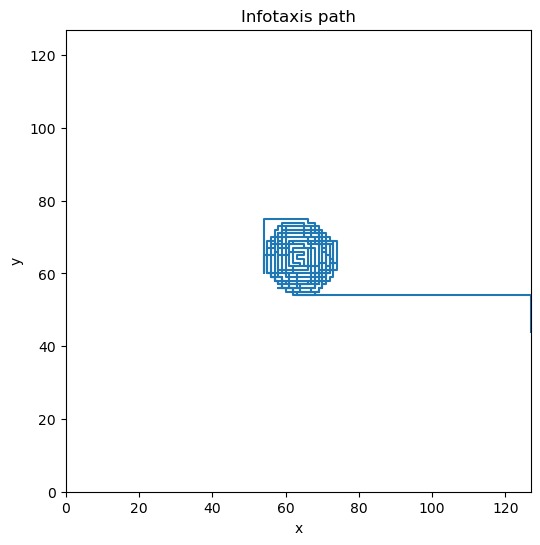

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(path_1[:,0], path_1[:,1])
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Infotaxis path')

plt.show()

In [8]:
path_2, debug_2, A_2 = infotaxis(10000, 70, 60, 64, 64, 128, 128, 10, 1, 1, 1, 0.6, -100)

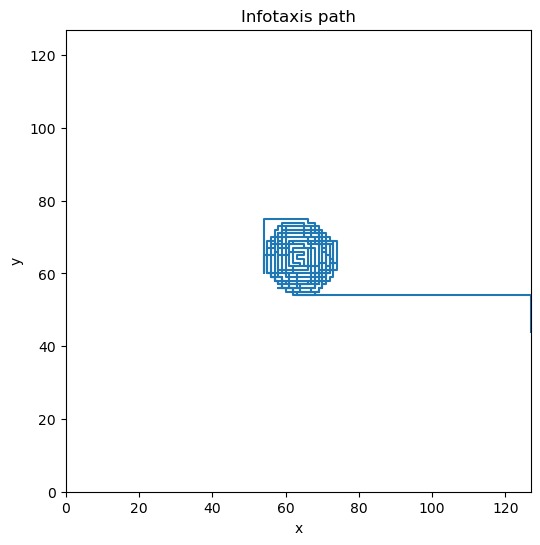

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(path_2[:,0], path_2[:,1])
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Infotaxis path')

plt.show()

In [12]:
np.array_equal(path_1, path_2)

True